In [1]:
%cd ..

/home/feodor/Jupyter/topological-illustrations


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import itertools

# Load the data

In [3]:
input_path = 'geodata/gebco_2024_n4.0_s-11.0_w118.0_e137.0_ascii.asc'
output_path = "geodata/banda_sea_heights.csv"

# Load ASCII file (modify according to structure)
data = np.loadtxt(input_path, skiprows=6)  # Skip metadata lines

# Convert to DataFrame and save
df = pd.DataFrame(data)
df.to_csv(output_path, index=False)

print(f'df.shape = {df.shape}')

df.shape = (3600, 4560)


In [4]:
heights = df.values

print(f'heights.shape = {heights.shape}')
print(f'heights.min = {heights.min()}')
print(f'heights.max = {heights.max()}')
print(f'heights.mean = {heights.mean()}')

heights.shape = (3600, 4560)
heights.min = -7601.0
heights.max = 4239.0
heights.mean = -1773.7913320540936


# Given Height Data Analysis

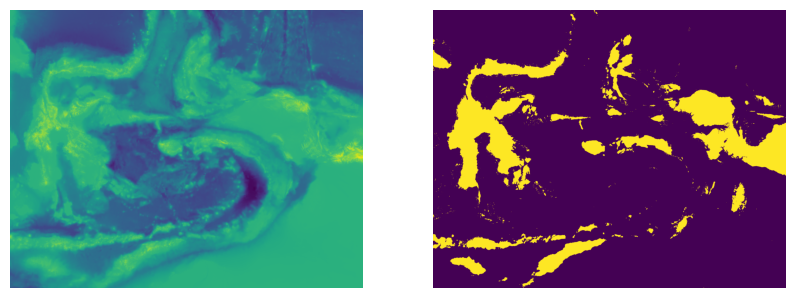

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].imshow(heights)
axs[1].imshow(heights >= 0)

axs[0].axis('off')
axs[1].axis('off')

plt.show()

## Height Distribution

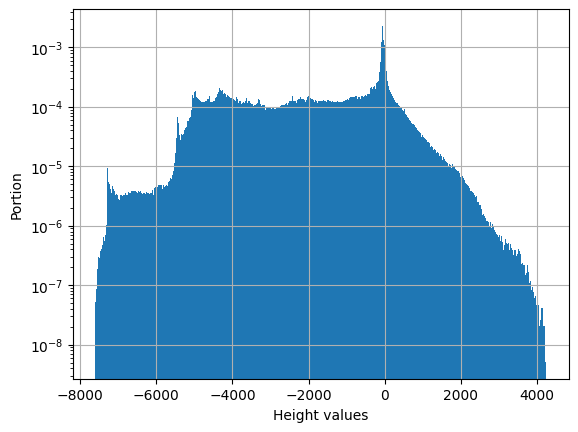

In [6]:
plt.hist(heights.reshape(-1), bins=np.linspace(heights.min(), heights.max(), 1000), density=True, log=True)

plt.xlabel('Height values')
plt.ylabel('Portion')
plt.grid(True)
plt.show()

## Extremums

In [7]:
def get_local_maximums(arr, framed=False):
    # finds the indices of local maxima in a 2D array.
    arr = np.asarray(arr)
    if not isinstance(arr, np.ndarray) or arr.ndim != 2:
        raise ValueError("Input must be a 2D NumPy array")
    
    if not framed:
        new_arr = -np.inf*np.ones(np.array(arr.shape, dtype=int) + 2)
        new_arr[1: -1, 1:-1] = arr
        return get_local_maximums(new_arr, framed=True)

    cond0 = arr[:-2, :-2] < arr[1:-1, 1:-1]
    cond1 = arr[:-2, 1:-1] < arr[1:-1, 1:-1]
    cond2 = arr[:-2, 2:] < arr[1:-1, 1:-1]
    cond3 = arr[1:-1, :-2] < arr[1:-1, 1:-1]
    cond4 = arr[1:-1, 2:] < arr[1:-1, 1:-1]
    cond5 = arr[2:, :-2] < arr[1:-1, 1:-1]
    cond6 = arr[2:, 1:-1] < arr[1:-1, 1:-1]
    cond7 = arr[2:, 2:] < arr[1:-1, 1:-1]

    return np.where(cond0 & cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7)

In [8]:
def get_local_minimums(arr, framed=False):
    # finds the indices of local minima in a 2D array
    arr = np.asarray(arr)
    if not isinstance(arr, np.ndarray) or arr.ndim != 2:
        raise ValueError("Input must be a 2D NumPy array")
    
    if not framed:
        new_arr = +np.inf*np.ones(np.array(arr.shape, dtype=int) + 2)
        new_arr[1: -1, 1:-1] = arr
        return get_local_minimums(new_arr, framed=True)

    cond0 = arr[:-2, :-2] > arr[1:-1, 1:-1]
    cond1 = arr[:-2, 1:-1] > arr[1:-1, 1:-1]
    cond2 = arr[:-2, 2:] > arr[1:-1, 1:-1]
    cond3 = arr[1:-1, :-2] > arr[1:-1, 1:-1]
    cond4 = arr[1:-1, 2:] > arr[1:-1, 1:-1]
    cond5 = arr[2:, :-2] > arr[1:-1, 1:-1]
    cond6 = arr[2:, 1:-1] > arr[1:-1, 1:-1]
    cond7 = arr[2:, 2:] > arr[1:-1, 1:-1]

    return np.where(cond0 & cond1 & cond2 & cond3 & cond4 & cond5 & cond6 & cond7)

In [9]:
def get_saddles(arr, framed=False):
    # finds the indices of saddles in a 2D array
    arr = np.asarray(arr)
    if not isinstance(arr, np.ndarray) or arr.ndim != 2:
        raise ValueError("Input must be a 2D NumPy array")
        
    if not framed:
        new_arr = np.nan*np.ones(np.array(arr.shape, dtype=int) + 2)
        new_arr[1: -1, 1:-1] = arr
        return get_saddles(new_arr, framed=True) 
        
    # Conditions for a saddle point:
    diag1_min = (arr[:-2, :-2] > arr[1:-1, 1:-1]) & (arr[2:, 2:] > arr[1:-1, 1:-1])
    diag1_max = (arr[:-2, :-2] < arr[1:-1, 1:-1]) & (arr[2:, 2:] < arr[1:-1, 1:-1])
    diag2_min = (arr[:-2, 2:] > arr[1:-1, 1:-1]) & (arr[2:, :-2] > arr[1:-1, 1:-1])
    diag2_max = (arr[:-2, 2:] < arr[1:-1, 1:-1]) & (arr[2:, :-2] < arr[1:-1, 1:-1])
    
    saddle_points = (diag1_min & diag2_max) | (diag1_max & diag2_min)
    
    return np.where(saddle_points)

In [10]:
local_maximums = get_local_maximums(heights)
local_minimums = get_local_minimums(heights)
saddles = get_saddles(heights)

print(f'Number of local maximums: {len(local_maximums[0])}')
print(f'Number of local minimums: {len(local_minimums[0])}')
print(f'Number of saddles: {len(saddles[0])}')

Number of local maximums: 82882
Number of local minimums: 66470
Number of saddles: 63335


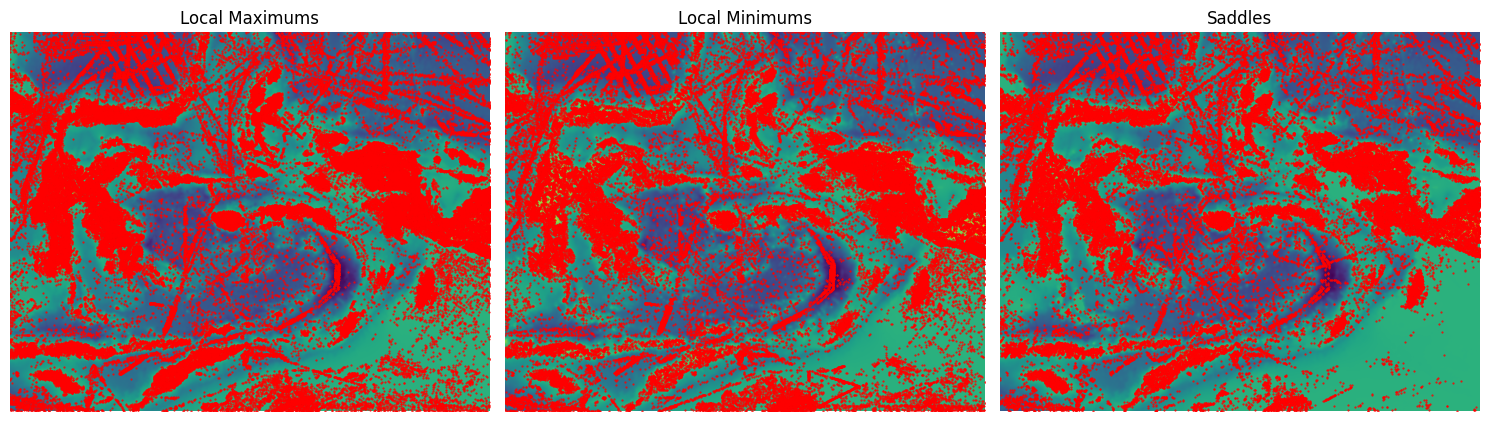

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

for i in range(3):
    axs[i].imshow(heights, cmap='viridis')
    axs[i].axis('off')

axs[0].set_title('Local Maximums')
axs[0].scatter(local_maximums[1], local_maximums[0], color='red', marker='.', s=1)

axs[1].set_title('Local Minimums')
axs[1].scatter(local_minimums[1], local_minimums[0], color='red', marker='.', s=1)

axs[2].set_title('Saddles')
axs[2].scatter(saddles[1], saddles[0], color='red', marker='.', s=1)

plt.tight_layout()
plt.show()

# Simplify

## Decrease Resolution

In [12]:
heights_decreased = sp.ndimage.zoom(heights, 0.1)
heights_decreased = heights_decreased.round()
heights_decreased.shape

(360, 456)

In [13]:
local_maximums = get_local_maximums(heights_decreased)
local_minimums = get_local_minimums(heights_decreased)
saddles = get_saddles(heights_decreased)

print(f'Number of local maximums: {len(local_maximums[0])}')
print(f'Number of local minimums: {len(local_minimums[0])}')
print(f'Number of saddles: {len(saddles[0])}')

Number of local maximums: 4558
Number of local minimums: 4009
Number of saddles: 3226


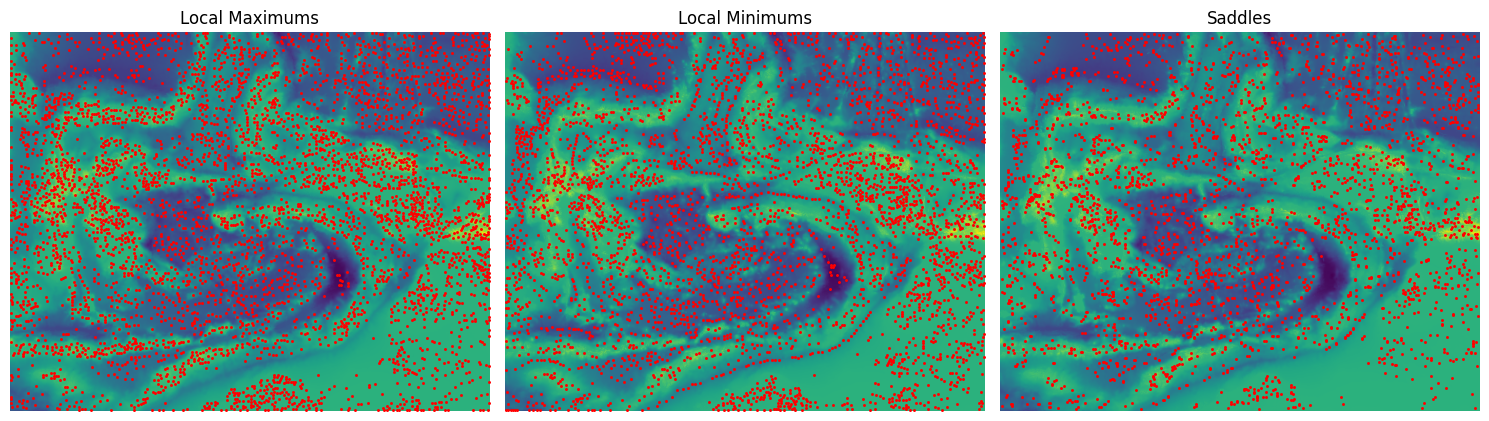

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

for i in range(3):
    axs[i].imshow(heights_decreased, cmap='viridis')
    axs[i].axis('off')

axs[0].set_title('Local Maximums')
axs[0].scatter(local_maximums[1], local_maximums[0], color='red', marker='.', s=5)

axs[1].set_title('Local Minimums')
axs[1].scatter(local_minimums[1], local_minimums[0], color='red', marker='.', s=5)

axs[2].set_title('Saddles')
axs[2].scatter(saddles[1], saddles[0], color='red', marker='.', s=5)

plt.tight_layout()
plt.show()

## Decrease Extremums by Smoothing

In [15]:
heights_smoothed = heights_decreased.copy()
heights_smoothed = sp.ndimage.gaussian_filter(heights_smoothed, sigma=2)
heights_smoothed = sp.ndimage.median_filter(heights_smoothed, size=6)

heights_smoothed.shape

(360, 456)

In [16]:
flat = np.linspace(0, 1, np.prod(heights_smoothed.shape)).reshape(heights_smoothed.shape) # plane to remove flat areas
flat *= 0.5*(np.unique(heights_smoothed)[1:] - np.unique(heights_smoothed)[:-1]).min()

local_maximums = get_local_maximums(heights_smoothed + flat)
local_minimums = get_local_minimums(heights_smoothed + flat)
saddles = get_saddles(heights_smoothed + flat)

print(f'Number of local maximums: {len(local_maximums[0])}')
print(f'Number of local minimums: {len(local_minimums[0])}')
print(f'Number of saddles: {len(saddles[0])}')

Number of local maximums: 163
Number of local minimums: 141
Number of saddles: 443


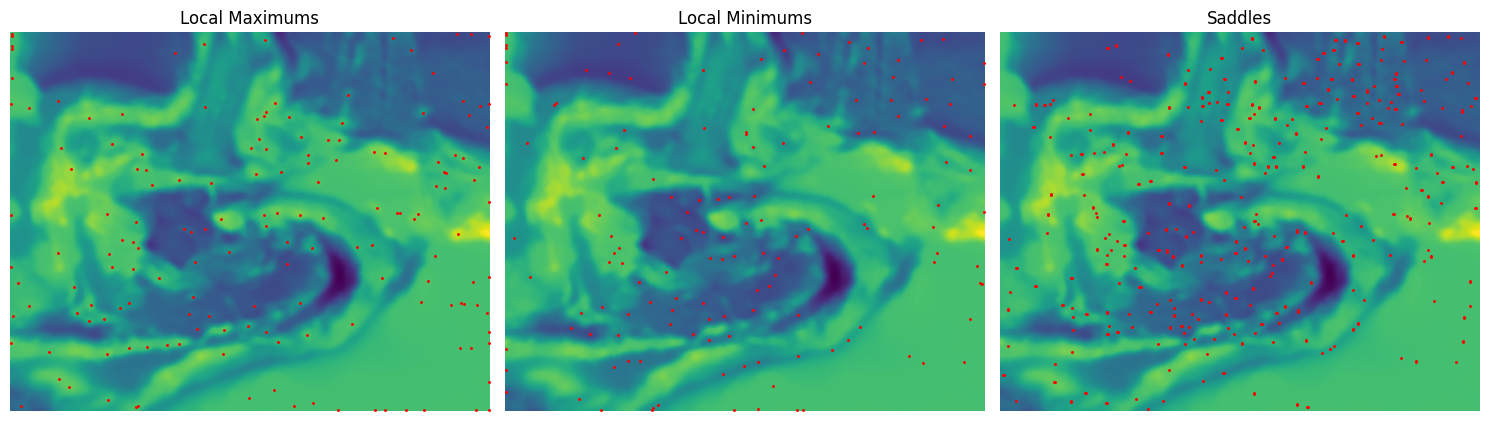

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

for i in range(3):
    axs[i].imshow(heights_smoothed, cmap='viridis')
    axs[i].axis('off')

axs[0].set_title('Local Maximums')
axs[0].scatter(local_maximums[1], local_maximums[0], color='red', marker='.', s=5)

axs[1].set_title('Local Minimums')
axs[1].scatter(local_minimums[1], local_minimums[0], color='red', marker='.', s=5)

axs[2].set_title('Saddles')
axs[2].scatter(saddles[1], saddles[0], color='red', marker='.', s=5)

plt.tight_layout()
plt.show()

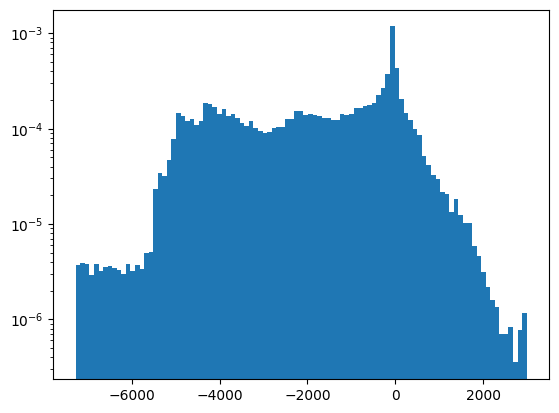

In [18]:
plt.hist(heights_smoothed.reshape([-1]), bins=np.linspace(heights_smoothed.min(), heights_smoothed.max(), 100), density=True, log=True)
plt.show()

In [19]:
len(np.unique(heights_smoothed.round()))/np.prod(heights_smoothed.round().shape)

np.float64(0.04761208576998051)

# Geting Cells

### Defining cells and their borders by myself

In [20]:
def get_cells(arr, connectivity=4):
    """
    Identifies and separates connected components (cells) of the same height level in a 2D NumPy array.

    Parameters:
    - arr: 2D NumPy array
    - connectivity: 4 (default) or 8, indicating the type of connectivity.

    Returns:
    - List of cells, where each cell is a list of (row, col) coordinates.
    """
    arr = np.asarray(arr)
    if arr.ndim != 2:
        raise ValueError("Input must be a 2D NumPy array")

    values = np.unique(arr)  # Unique height levels
    cells = []
    
    # Define connectivity structure: 4-connectivity or 8-connectivity
    if connectivity == 4:
        structure = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])  # 4-connectivity
    elif connectivity == 8:
        structure = np.ones((3, 3))  # 8-connectivity
    else:
        raise ValueError("Connectivity must be 4 or 8")

    for value in tqdm(values, total=len(values)):
        mask = arr == value  # Binary mask for the current height
        labeled_array, num_features = sp.ndimage.label(mask, structure)  # Identify components

        for i in range(1, num_features + 1):
            cells.append(np.argwhere(labeled_array == i))  # Store component indices

    return cells


In [21]:
rounder = 200
heights_rounded = (heights_smoothed/rounder).round()*rounder

cells_smoothed = get_cells(heights_rounded)

print(f'There are {len(cells_smoothed)} cells.')

  0%|          | 0/52 [00:00<?, ?it/s]

There are 16741 cells.


  0%|          | 0/16741 [00:00<?, ?it/s]

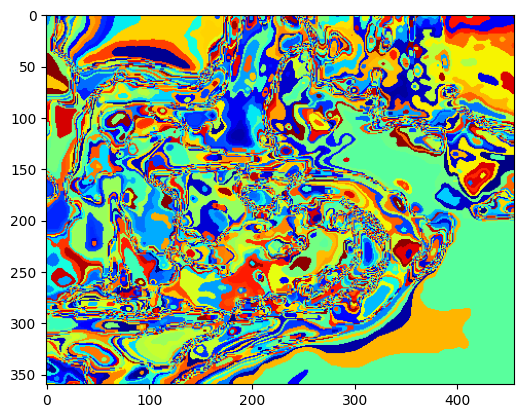

In [22]:
cells_map = np.nan*heights_smoothed
for i_cell, cell in tqdm(enumerate(cells_smoothed), total=len(cells_smoothed)):
    cells_map[cell[:, 0], cell[:, 1]] = np.random.random()#i_cell
plt.imshow(cells_map, cmap='jet')

In [23]:
def get_border(cell, inner=None):
    """
    Returns the indices of cell borders:

    Parameters:
    -----------
    cell: np.array shape (n, 2)
        The indices of the cell

    inner: bool or None
        Returns only indices of points in cell, if True
        Returns only indices of points outside of cell, if False
        Returns all border indices if None

    Returns:
    --------
    np.array shape (k, 2)
    """
    cell = np.asarray(cell)
    if cell.ndim != 2:
        raise ValueError("Input cell must have shape (N, 2)")
    if cell.shape[1] != 2:
        raise ValueError("Input cell must have shape (N, 2)")

    shift = cell.min(axis=0) - 1

    arr = np.zeros(cell.max(axis=0) - cell.min(axis=0) + 3)
    arr[tuple((cell - shift).transpose())] = 1

    border = np.array([arr[1:, 1:], arr[1:, :-1], arr[:-1, 1:], arr[:-1, :-1]])
    border = (border == True).any(axis=0) & (border == False).any(axis=0)

    res = np.zeros(arr.shape, dtype=bool)
    res[:-1, :-1] |= border
    res[1:, :-1] |= border
    res[:-1, 1:] |= border
    res[1:, 1:] |= border

    if inner is None:
        pass
    elif inner:
        res = np.logical_and(res, arr)
    else:
        res = np.logical_and(res, np.logical_not(arr))

    return np.transpose(np.where(res)) + shift

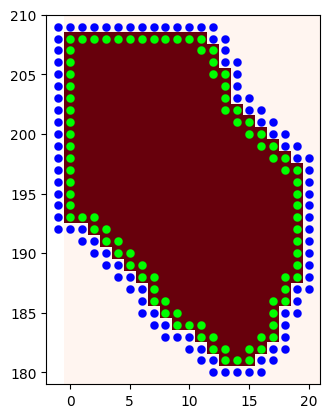

In [24]:
cells_lengths = np.array([len(cell) for cell in cells_smoothed])
cell = cells_smoothed[np.random.choice(np.where(cells_lengths > np.unique(cells_lengths).mean())[0])]

# plot cell
to_plot = 0*heights_smoothed
to_plot[cell[:, 0], cell[:, 1]] = 1

plt.imshow(to_plot, cmap='Reds', vmin=0, vmax=1)

# plot inner border
border = get_border(cell, inner=True)
plt.scatter(border[:, 1], border[:, 0], color='lime', linewidth=0.1)

# plot outer border
border = get_border(cell, inner=False)
plt.scatter(border[:, 1], border[:, 0], color='blue', linewidth=0.1)


plt.ylim(cell[:, 0].min() - 2, cell[:, 0].max() + 2)
plt.xlim(cell[:, 1].min() - 2, cell[:, 1].max() + 2)
plt.show()

### by skimage

In [25]:
from skimage.segmentation import felzenszwalb, find_boundaries

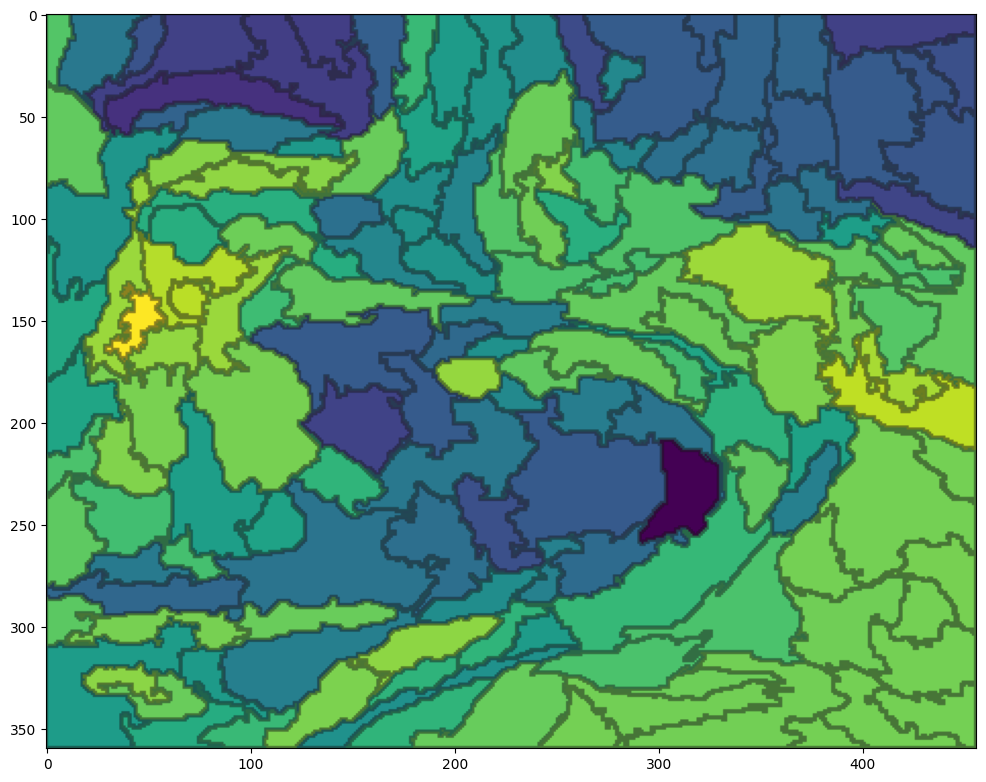

In [26]:
# find segments
segments_matrix = felzenszwalb(heights_decreased, scale=100, sigma=0.1, min_size=200)
#segments_matrix = felzenszwalb(heights_smoothed, scale=100, sigma=0.1, min_size=200)

# find mean hight values for segments
segments_heights = np.nan*segments_matrix
for segment_index in np.unique(segments_matrix):
    segments_heights[segments_matrix == segment_index] = heights_decreased[segments_matrix == segment_index].mean()


segments = [np.argwhere(segments_matrix == i) for i in np.unique(segments_matrix)]
segments_borders = [get_border(segment, inner=None) for segment in segments]

all_borders = np.concatenate(segments_borders)
all_borders = all_borders[((all_borders >= 0)&(all_borders < segments_matrix.shape)).all(axis=1)]
border_matrix = np.zeros(segments_matrix.shape)
border_matrix[*all_borders.transpose()] = 1

plt.figure(figsize=[12, 15])
plt.imshow(segments_heights)
plt.imshow(np.where(np.logical_not(border_matrix), np.nan, border_matrix), cmap='Greys', vmin=0, vmax=1.1, alpha=0.5)
plt.show()

In [27]:
def get_cell_center(cell, border=None):
    # returns the center of the cell
    if border is None:
        border = get_border(cell, inner=False)
    
    def far_from_border(center):
        return np.linalg.norm(border - center, axis=1).min()
    
    center = cell[0]
    for point in cell:
        if far_from_border(point) > far_from_border(center):
            center = point
    return center

  0%|          | 0/158 [00:00<?, ?it/s]

  0%|          | 0/12403 [00:00<?, ?it/s]

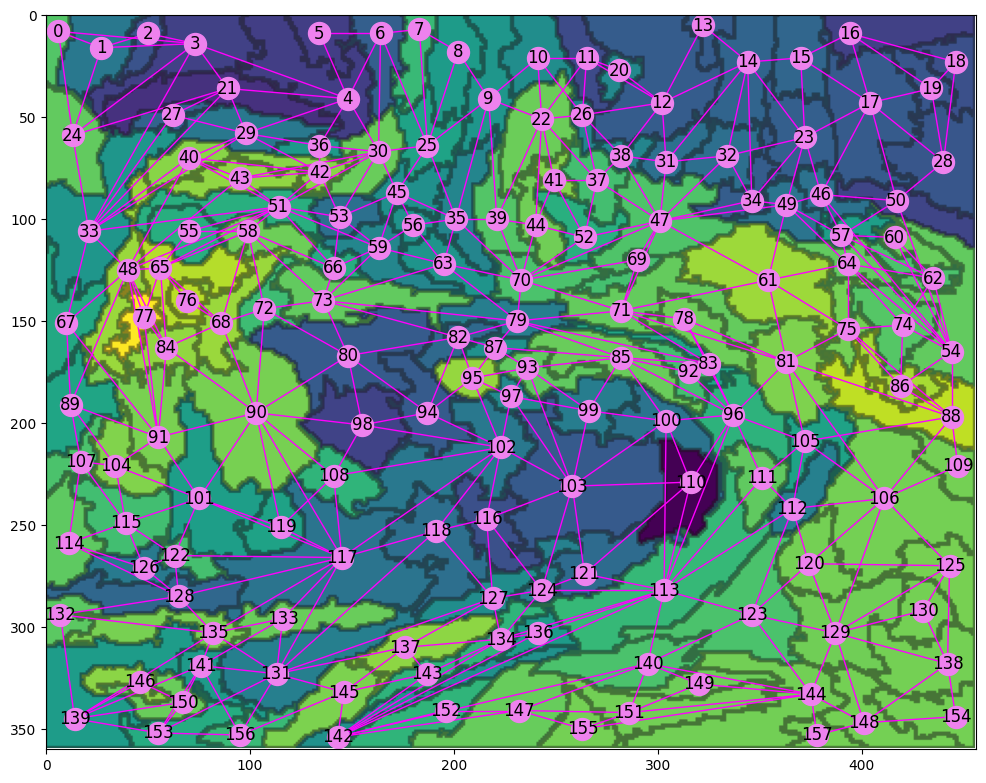

In [28]:
segments_centers = np.array([get_cell_center(cell, border) for cell, border in tqdm(zip(segments, segments_borders), total=len(segments))])

# the simplies connections
edges = []
for i, j in tqdm(itertools.combinations(range(len(segments)), 2), total=len(segments)*(len(segments) - 1)//2):
    border_i = segments_borders[i]
    border_j = segments_borders[j]

    set_i = set(map(tuple, border_i))
    set_j = set(map(tuple, border_j))
    if  len(list(set_i & set_j)) > 0:
        edges.append((i, j))

# create graph
G = nx.Graph()
G.add_nodes_from(range(len(segments)))
G.add_edges_from(edges)


fig, ax = plt.subplots(1, 1, figsize=[12, 15])
ax.imshow(segments_heights)
ax.imshow(np.where(np.logical_not(border_matrix), np.nan, border_matrix), cmap='Greys', vmin=0, vmax=1.1, alpha=0.5)
nx.draw_networkx(G, pos=segments_centers[:, [1, 0]], ax=ax, edge_color='magenta', node_color='violet', with_labels=True, node_size=250, width=1.0, hide_ticks=False)

ax.set_xlim(0, segments_matrix.shape[1])
ax.set_ylim(segments_matrix.shape[0], 0)


plt.show()

In [29]:
def get_number_of_components_in_segment(segment, structure=np.ones([3, 3])):
    """
    Returns the number of components in a segment

    Parameters:
    -----------
    segment: np.array shape (n, 2)
        The indices of the segment

    structure: np.array shape (3, 3)
        The structure of the segment (default is 8-connectivity)
    
    Returns:
    --------
    int
        The number of components in the segment   
    """
    segment = np.asarray(segment)
    if segment.ndim != 2:
        raise ValueError("Input segment must have shape (N, 2)")
    if segment.shape[1] != 2:
        raise ValueError("Input segment must have shape (N, 2)")

    arr = np.zeros(segment.max(axis=0) - segment.min(axis=0) + 6)
    arr[tuple((segment - segment.min(axis=0) + 1).transpose())] = 1

    return sp.ndimage.label(arr, structure=structure)[1]

In [30]:
def get_components_in_segment(segment, structure=np.ones([3, 3])):
    """
    Returns the number of components in a segment

    Parameters:
    -----------
    segment: np.array shape (n, 2)
        The indices of the segment

    structure: np.array shape (3, 3)
        The structure of the segment (default is 8-connectivity)
    
    Returns:
    --------
    list of np.array shape (..., 2)
        The indices of the components in the segment   
    """
    segment = np.asarray(segment)
    if segment.ndim != 2:
        raise ValueError("Input segment must have shape (N, 2)")
    if segment.shape[1] != 2:
        raise ValueError("Input segment must have shape (N, 2)")

    arr = np.zeros(segment.max(axis=0) - segment.min(axis=0) + 6)
    arr[tuple((segment - segment.min(axis=0) + 1).transpose())] = 1

    res_labels = sp.ndimage.label(arr, structure=structure)[0]
    res = []
    for i in np.unique(res_labels):
        component = np.argwhere(res_labels == i)
        if (segment - segment.min(axis=0) + 1 == component[0]).all(axis=1).any():
            res.append(component + segment.min(axis=0) - 1)
        
    return res


number_of_components_in_segment: 9
len(list_of_components_in_segment): 9


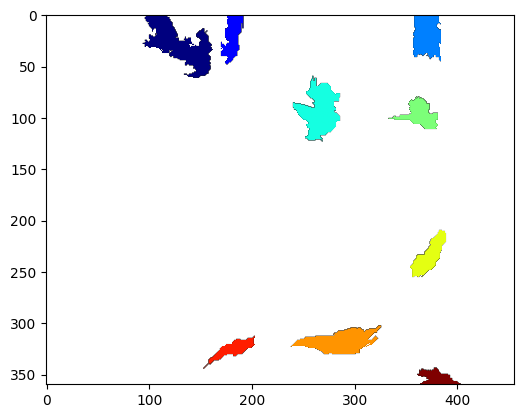

In [31]:
cell = np.concatenate(np.random.choice(np.array(segments, dtype=object), 10, replace=False))
                      
to_plot = np.zeros(segments_matrix.shape)
to_plot[cell[:, 0], cell[:, 1]] = 1
plt.imshow(to_plot, cmap='Greys', vmin=0, vmax=1)

number_of_components_in_segment = get_number_of_components_in_segment(cell)
print(f'number_of_components_in_segment: {number_of_components_in_segment}')

list_of_components_in_segment = get_components_in_segment(cell)
print(f'len(list_of_components_in_segment): {len(list_of_components_in_segment)}')

to_plot = np.nan*np.zeros(segments_matrix.shape)
for i, component in enumerate(list_of_components_in_segment):
    to_plot[component[:, 0], component[:, 1]] = i + 1

plt.imshow(to_plot, cmap='jet')
plt.show()

In [32]:
def get_border_components(segments, borders=None, g=None):
    """
    Returns the number of borders for each cell connection

    Parameters:
    -----------
    segments: list of np.array shape (n, 2)
        The indices of the segments

    borders: list of np.array shape (k, 2)
        The indices of the borders of the segments
        If None, the borders are calculated for each segment
        (default is None)

    g: networkx.Graph
        The graph of the segments
        If None, the graph is calculated for each segment
        (default is None)

    Returns:
    --------
    dict
        A dictionary with the indices of the segments as keys
        and the number of borders as values
    """
    if borders is None:
        borders = [get_border(segment, inner=None) for segment in segments]

    if g is None:
        # the simpliest connections
        edges = []
        for i, j in tqdm(itertools.combinations(range(len(segments)), 2), total=len(segments)*(len(segments) - 1)//2):
            border_i = borders[i]
            border_j = borders[j]

            set_i = set(map(tuple, border_i))
            set_j = set(map(tuple, border_j))
            if  len(list(set_i & set_j)) > 0:
                edges.append((i, j))
        # create graph
        g = nx.Graph()
        g.add_nodes_from(range(len(segments)))
        g.add_edges_from(edges)
    
    border_components = {}
    for edge in g.edges:
        border0 = borders[edge[0]]
        border1 = borders[edge[1]]
        
        set0 = set(map(tuple, border0))
        set1 = set(map(tuple, border1))
        border_intersection = np.array(list(set0 & set1))
        if border_intersection.shape[0] == 0:
            continue
        border_components[edge] = get_components_in_segment(border_intersection, structure=np.ones([3, 3]))
    
    return border_components


        
    

In [33]:
def get_border_counts(segments, borders=None, g=None):
    """
    Returns the number of borders for each cell connection

    Parameters:
    -----------
    segments: list of np.array shape (n, 2)
        The indices of the segments

    borders: list of np.array shape (k, 2)
        The indices of the borders of the segments
        If None, the borders are calculated for each segment
        (default is None)

    g: networkx.Graph
        The graph of the segments
        If None, the graph is calculated for each segment
        (default is None)
    
    Returns:
    --------
    np.array shape (n, n)
        The number of borders for each cell connection
    """
    if borders is None:
        borders = [get_border(segment, inner=None) for segment in segments]

    if g is None:
        # the simpliest connections
        edges = []
        for i, j in tqdm(itertools.combinations(range(len(segments)), 2), total=len(segments)*(len(segments) - 1)//2):
            border_i = borders[i]
            border_j = borders[j]

            set_i = set(map(tuple, border_i))
            set_j = set(map(tuple, border_j))
            if  len(list(set_i & set_j)) > 0:
                edges.append((i, j))
        # create graph
        g = nx.Graph()
        g.add_nodes_from(range(len(segments)))
        g.add_edges_from(edges)


    border_counts = np.zeros((len(segments), len(segments)), dtype=int)
    for edge in g.edges:
        border0 = borders[edge[0]]
        border1 = borders[edge[1]]
        
        set0 = set(map(tuple, border0))
        set1 = set(map(tuple, border1))
        border_intersection = np.array(list(set0 & set1))
        
        num_components = get_number_of_components_in_segment(border_intersection)
        border_counts[edge[0], edge[1]] = num_components
        border_counts[edge[1], edge[0]] = num_components

    return border_counts

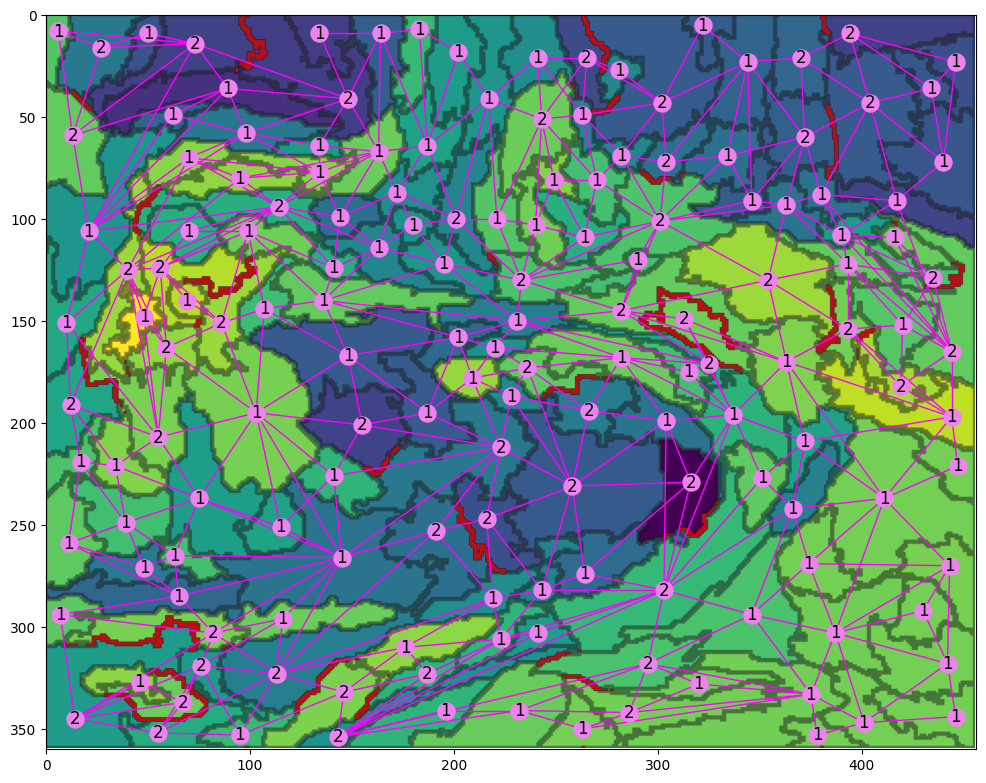

In [34]:
border_counts = get_border_counts(segments, borders=segments_borders, g=G)
border_components = get_border_components(segments, borders=segments_borders, g=G)

repeated_borders = np.nan*segments_heights
for (i, j), border in border_components.items():
    if len(border) > 1:
        for component in border:
            repeated_borders[component[:, 0], component[:, 1]] = 1

segments_labels = {i: border_counts[i].max() for i in range(len(segments))}

fig, ax = plt.subplots(1, 1, figsize=[12, 15])
ax.imshow(segments_heights)
ax.imshow(np.where(np.logical_not(border_matrix), np.nan, border_matrix), cmap='Greys', vmin=0, vmax=1.1, alpha=0.5)
nx.draw_networkx(G, pos=segments_centers[:, [1, 0]], ax=ax, edge_color='magenta', node_color='violet', labels=segments_labels, node_size=150, width=1.0, hide_ticks=False)


ax.imshow(repeated_borders, cmap='Reds', vmin=0, vmax=1.2)


ax.set_xlim(0, segments_matrix.shape[1])
ax.set_ylim(segments_matrix.shape[0], 0)

plt.show()

In [ ]:
def distance_to_area(x, area):
    """
    Returns the distance from x to the area

    Parameters:
    -----------
    x: np.array shape (k, 2)
        The coordinates of the points
    
    area: np.array shape (n, 2)
        The coordinates of the area
    
    Returns:
    --------
    np.array shape (k,)
        The distance from x to the area
    """
    x = np.asarray(x)
    area = np.asarray(area)
    if x.ndim != 2:
        raise ValueError("Input x must have shape (N, 2)")
    if area.ndim != 2:
        raise ValueError("Input area must have shape (N, 2)")
    if x.shape[1] != 2:
        raise ValueError("Input x must have shape (N, 2)")
    if area.shape[1] != 2:
        raise ValueError("Input area must have shape (N, 2)")

    return np.linalg.norm(x[:, None] - area[None], axis=2).min(axis=1)

def separate_segment(segment, separated_areas=None):
    """
    Separates the segment into separated areas
    
    Parameters:
    -----------
    segment: np.array shape (n, 2)
        The indices of the segment
    separated_areas: list of np.array shape (k, 2)
        The indices of the separated areas
        If None or empty list, will return the segment as is
        (default is None)
    
    Returns:
    --------
    list of np.array shape (m, 2)
        The indices of the separated areas
    """
    segment = np.asarray(segment)
    if segment.ndim != 2:
        raise ValueError("Input segment must have shape (N, 2)")
    if segment.shape[1] != 2:
        raise ValueError("Input segment must have shape (N, 2)")
    
    if separated_areas is None:
        return [segment]
    if len(separated_areas) == 0:
        return [segment]
    
    area_distances = np.array([distance_to_area(segment, area) for area in separated_areas])
    area_distances = area_distances.argmin(axis=0)

    separated_result= [segment[area_distances == i] for i in range(len(separated_areas))]
    return separated_result


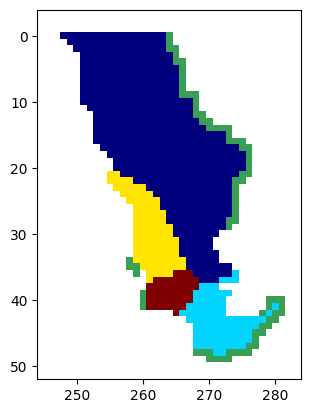

In [109]:
segment_index = 11
segment = segments[segment_index]
segment_repeating_borders = [value for (i, j), value in border_components.items() if ((i == segment_index) or (j == segment_index)) and len(value) > 1]
segment_repeating_subborders = []

to_plot = np.nan*np.zeros(segments_matrix.shape)
to_plot[segment[:, 0], segment[:, 1]] = 1
plt.imshow(to_plot, cmap='Greys', vmin=0, vmax=1)
to_plot = np.nan*np.zeros(segments_matrix.shape)
for border in segment_repeating_borders:
    for subborder in border:
        segment_repeating_subborders.append(subborder)
        to_plot[subborder[:, 0], subborder[:, 1]] = 1
plt.imshow(to_plot, cmap='Greens', vmin=0, vmax=1.5)

separated_segments = separate_segment(segment, separated_areas=segment_repeating_subborders)

to_plot = np.nan*np.zeros(segments_matrix.shape)
for i, separated_segment in enumerate(separated_segments):
    to_plot[separated_segment[:, 0], separated_segment[:, 1]] = i
plt.imshow(to_plot, cmap='jet')



plt.xlim(segment[:, 1].min() - 4, segment[:, 1].max() + 4)
plt.ylim(segment[:, 0].max() + 4, segment[:, 0].min() - 4)
plt.show()